# Branching Gaussian Processes using Tensor flow
## February 4, 2016
## Alexis Boukouvalas
## with James Hensman, Magnus Rattray


Inferring perturbation time
===


*Jing* and *Magnus* developed a tractable GP model for the identification of a single perturbation point.

<center><img src="figs/crossingKernel.png" height="200" width="200" ></center>

1. Define a novel kernel that constrains two functions $f$ and $g$ to *cross* at a single point.
1. Develop conditional kernel where $f$ and $g$ are assumed to be the identical prior to the crossing point.
1. Bifurcation point is identified by numerically approximating the posterior and selecting a point estimate. This is a model selection approach.

1. Hyperparameters are estimated by assuming the two functions are independent, that is they do not cross.
1. Model used "to identify at which time point a gene becomes differentially expressed in time course gene expression data under two various conditions.
1. Both GPy and R implementations are available

The approach relies on a few key assumptions:
1. All data points have been labelled as to which function ($f/g$) they belong to.
2. The ordering of time points is assumed known and fixed.

Tensor flow
===
1. "Easy to transition from research prototype to production system"
1. "not complete; it is intended to be built upon, improved, and extended"
1. Not as interactive, more laborious.
1. Never again derivatives!
1. Parallel execution derived from graph to GPU/CPU.
1. Promised distributed version.
1. [GPflow](https://github.com/GPflow/GPflow) - Gaussian process models in tensor flow under development.

Branching Gaussian processes (GP)
===
<img src="figs/branchingGPtreeBig.png" height="800" width="1000">

Branching Gaussian processes (GP)
===
We wish to extend the perturbation approach to:

1. Extend the kernel to multiple branching points assuming a tree structure. 
1. Infer the function labels; we do this by assigning point to the most likely function that generated them.
1. Perform efficient inference by maximizing a collapsed variational bound.
1. Efficient implementation using [Google Tensorflow](https://www.tensorflow.org).
1. Assume the time order is not given but also has be inferred - known as pseudotime inference in single cell literature.

Structure of the talk
===
1. Crossing kernel.
1. The tree prior.
1. Tree Branching kernel.
1. Probabilistic model

Crossing kernel
===
The crossing kernel for any number of points is:

$$
\begin{align*}
p\left(f\left(X\right),g\left(Z\right)\right)&=
\int p\left(f|u\right)p\left(g|u\right)p\left(u\right)du \\
&=
N\left(\begin{pmatrix}f\\g\end{pmatrix}
\left|0,\begin{pmatrix}K_{X} & k_{X}k_{p}^{-1}k_{Z}^{T}\\
k_{Z}k_{p}^{-1}k_{X}^{T} & K_{Z}
\end{pmatrix}\right.\right) \\
\end{align*}
$$
where $k_{X}=K\left(X,x_{p}\right)$ the $N\times1$ train-test matrix and $k_{p}=K\left(x_{p},x_{p}\right)$ the branching kernel.

# Required libraries

In [1]:
import sys
sys.path.append('../')
import tensorflow as tf
import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
%matplotlib inline
import BranchingTree as bt
import BranchingKernels as kernels
np.set_printoptions(precision=4) # precision to print numpy array
plt.rcParams['figure.figsize'] = (8.0, 6.0)

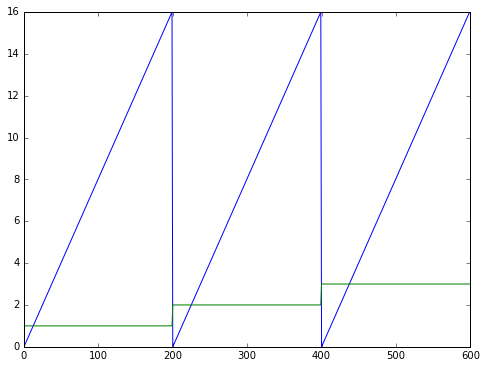

In [2]:
#construct a X matrix
N = 200 # how many points per function
Bc = np.atleast_2d(np.array([3,6,14])).T
t1 = np.linspace(0,16,N) # same domain
t2 = np.linspace(0,16,N)
t3 = np.linspace(0,16,N)
X1 = np.vstack((t1, t1*0+1)).T
X2 = np.vstack((t1, t1*0+2)).T
X3 = np.vstack((t1, t1*0+3)).T
Xc = np.vstack((X1, X2,X3))
plt.plot(Xc)

(600, 2)


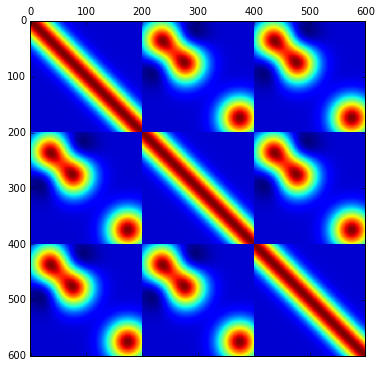

In [3]:
print Xc.shape
Knp = kernels.KCrossFullCov(Xc, Xc, Bc,lenscale2B=4)
plt.matshow(Knp)

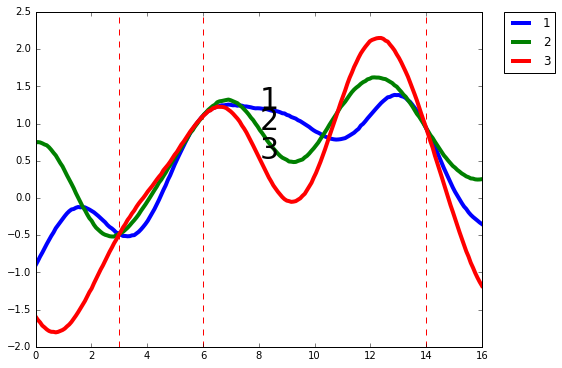

In [4]:
kernels.PlotSample(Knp,3,Xc,Bc,lw=4,fs=30)

Trees
===
Underlying tree structure where at each branching point, the function bifurcates. 

Compute 3-D tensor that maps all pairs of functions $f_i, f_j$ to set of crossing points $b_{ij}$.
1. Get path from root to each function, $P_i$, $P_j$. Path includes all branching points traversed including both endpoints of function.
1. If $P_i \subset P_j$ or $P_j \subset P_i$, functions cross all along longest path including its descendants.
1. Not subsets, find path to common ancestor.



Trees
===
<img src="figs/branchingGPtreeSmallFL.png" height="300" width="600">

In [5]:
fBigTree = False
N = 50 # how many points per function
if(fBigTree):
    tree = bt.BinaryBranchingTree(0,20)
    tree.add(None,1,3)
    tree.add(1,2,6)
    tree.add(1,3,12)
    tree.add(2,4,8)
    tree.add(2,5,11)
    tree.add(3,6,15)
    tree.add(3,7,16)
    tree.add(4,8,17)
else:
    tree = bt.BinaryBranchingTree(0,20)
    tree.add(None,1,3)
    tree.add(1,2,6)
    tree.add(1,3,12)
(fm, fmb) = tree.GetFunctionBranchTensor()
#print fmb
# First number is up, second number is down the tree
tree.printTree()

---------------------------2(6)[4,5]
------------------1(3)[2,3]
---------------------------3(12)[6,7]


Trees
===
<center><img src="figs/branchingGPtreeSmallFL.png" height="600" width="600"></center>

In [6]:
fi,fj=6,5
print 'Functions ('+str(fi)+','+str(fj) + ') cross ' + str(fm[fi-1,fj-1,:])

Functions (6,5) cross [  1.  nan  nan]


In [7]:
# functions 1,3 cross all along bottom subbranch
fi,fj=1,3
print 'Functions ('+str(fi)+','+str(fj) + ') cross ' + str(fm[fi-1,fj-1,:])

fi,fj=1,6
print 'Functions ('+str(fi)+','+str(fj) + ') cross ' + str(fm[fi-1,fj-1,:])

fi,fj=3,6
print 'Functions ('+str(fi)+','+str(fj) + ') cross ' + str(fm[fi-1,fj-1,:])

print 'Path to function ' + str(fj) + str(tree.GetFunctionPath(fj))

if(fBigTree):
    # only cross at root
    fi,fj=11,15
    print 'Functions ('+str(fi)+','+str(fj) + ') cross ' + str(fm[fi-1,fj-1,:])

# only cross at root
fi,fj=1,2
print 'Functions ('+str(fi)+','+str(fj) + ') cross ' + str(fm[fi-1,fj-1,:])


Functions (1,3) cross [  1.   3.  nan]
Functions (1,6) cross [  1.   3.  nan]
Functions (3,6) cross [  1.   3.  nan]
Path to function 6[1, 3, 6]
Functions (1,2) cross [  1.   2.  nan]


## Generate design matrix
Two dimensional representation with second dimension containing the function label.

In [8]:
df=tree.GetFunctionDomains()
print 'Function domains, each row contains the lower and upper bound \n of that function. 1-based counting.'
print df
m = df.shape[0] # number of functions
fi=0
domf = df[fi,]
t = np.atleast_2d(np.linspace(domf[0],domf[1],N)).T
x = (fi+1) * np.ones((N,1))
X = np.hstack((t,x))
for fi in range(1,m):
    domf = df[fi,]
    t = np.atleast_2d(np.linspace(domf[0],domf[1],N)).T
    x = (fi+1) * np.ones((N,1))
    X = np.vstack( (X, np.hstack( (t,x)) ) )  

Function domains, each row contains the lower and upper bound 
 of that function. 1-based counting.
[[  0.   3.]
 [  3.   6.]
 [  3.  12.]
 [  6.  20.]
 [  6.  20.]
 [ 12.  20.]
 [ 12.  20.]]


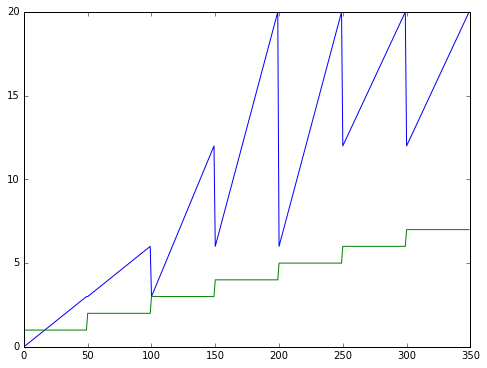

In [9]:
plt.plot(X)

# Setup tensor flow graph

In [10]:
nb = tree.GetNumberOfBranchPts()
M = 2*nb+1 # number of functions
B = tree.GetBranchValuesAsArray().T # get list of branch points

D = 2 # dimensionality, only used for checking dimensions, could skip
Xs = tf.placeholder("float64", shape=[None, D], name='Xs')
Ys = tf.placeholder("float64", shape=[None, D], name='Ys')
lenScale = tf.Variable(2*tf.ones([1,1],tf.float64),name='lenscale')
Bs =  tf.placeholder("float64", shape=(M,M,nb),name='B')

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())  # sets all variables

In [11]:
def rbfKernel(X,Y):
    with tf.name_scope("RBFkernel") as scope:
        a = tf.square(X/lenScale) + tf.square((tf.transpose(Y)/lenScale))
        b = 2*tf.matmul(X/lenScale,tf.transpose(Y)/lenScale)
        return tf.exp(-0.5 * (a-b), name='RBF')

<center><img src="figs/tensorboard_rbf.png" height="280" width="280"></center>

In [12]:
def KSplitMultipleLoopTF(Xs,Ys,fmb):
    # Need m, number of branch points, fmb tensor of branch points
    t1s = tf.expand_dims(Xs[:,0], 1) # N X 1
    t2s = tf.expand_dims(Ys[:,0], 1)
    i1s = tf.expand_dims(Xs[:,1], 1)
    i2s = tf.expand_dims(Ys[:,1], 1)    
    i1s_matrix = tf.tile(i1s,tf.reverse(tf.shape(i1s), [True]))
    i2s_matrix = tf.tile(i2s,tf.reverse(tf.shape(i2s), [True]))
    i2s_matrixT = tf.transpose(i2s_matrix)
    
    Ktts = rbfKernel(t1s, t2s) # N*M X N*M
    with tf.name_scope("kttscope") as scope:
        same_functions = tf.equal(i1s_matrix,tf.transpose(i2s_matrix), name='FiEQFj')
        K_s = tf.select(same_functions,Ktts,Ktts, name='selectFiEQFj') # just setup matrix with block diagonal
        Khist = tf.histogram_summary('Ktt',K_s)

    m = fmb.shape[0]
    for fi in range(m):
        for fj in range(m):
            if (fi != fj):
                with tf.name_scope("f"+str(fi)+"f"+str(fj)) as scope:
                    # much easier to remove nans before tensorflow 
                    bnan = tf.constant(fmb[fi,fj,~np.isnan(fmb[fi,fj,:])],tf.float64)
                    fi_s = tf.constant(fi+1,tf.int32,name='function' + str(fi))
                    fj_s = tf.constant(fj+1,tf.int32,name='function' + str(fj))

                    i1s_matrixInt = tf.cast(i1s_matrix, tf.int32)
                    i2s_matrixTInt = tf.cast(i2s_matrixT, tf.int32)

                    fiFilter = fi_s * tf.ones_like(i1s_matrixInt,tf.int32)
                    fjFilter = fj_s * tf.ones_like(i2s_matrixTInt,tf.int32) # must be transpose

                    #print fjFilter.eval(feed_dict={Xs: X, Ys: X, lenScale:2,Bs:B})

                    f1F = tf.equal(i1s_matrixInt,  fiFilter, name='indexF'+str(fi))
                    f2F = tf.equal(i2s_matrixTInt, fjFilter, name='indexF'+str(fj))

                    t12F = tf.logical_and(f1F,f2F, name='F'+str(fi) + 'andF' + str(fj))

                    Bs = tf.expand_dims(bnan,1) # make a column vector

                    kbb = rbfKernel(Bs,Bs)
                    Kbbs_inv = tf.matrix_inverse(kbb, name='invKbb') # B X B
                    Kb1s = rbfKernel(t1s,Bs) # N*m X B
                    Kb2s = rbfKernel(t2s,Bs) # N*m X B

                    K_crosss = tf.matmul(tf.matmul(Kb1s,Kbbs_inv), tf.transpose(Kb2s), name='Kt1_Bi_invBB_KBt2')    

                    K_s = tf.select(t12F, K_crosss, K_s, name='selectIndex')
                    Khist = tf.histogram_summary('KT'+str(fi_s) + 'andT' + str(fj), K_s)
    return K_s

In [13]:
Kf=KSplitMultipleLoopTF(Xs,Ys,fmb)

init = tf.initialize_all_variables()
with sess.as_default():
    Kfres=Kf.eval(feed_dict={Xs: X, Ys: X, lenScale:2})
    # Merge all the summaries and write them out to /tmp/mnist_logs
    merged = tf.merge_all_summaries()
    writer = tf.train.SummaryWriter("logTF", sess.graph_def)

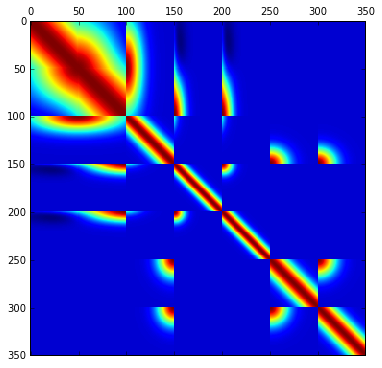

In [14]:
plt.matshow(Kfres)

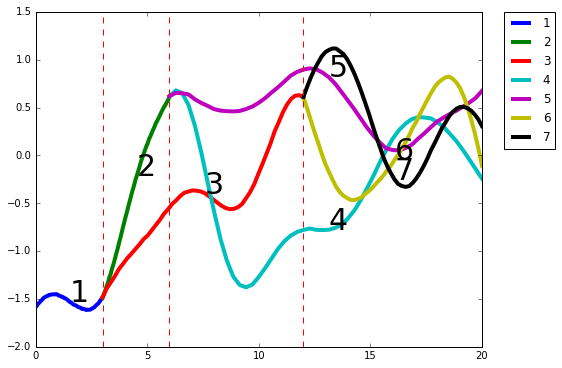

In [15]:
kernels.PlotSample(Kfres,M,X,B,lw=4,fs=30)

# Extend the OMG Model
1. $M$ different latent functions, indicator matrix $Z$.
1. The likelihood conditional on knowning the labels and function values $F$
$$ p\left(Y|F,Z\right) = \prod_{n=1}^N \prod_{m=1}^M N\left( Y_n | F_m, \sigma^2 \right)^{Z_{nm}} $$
1. Multinomial prior on indicators and GP prior over latent functions.
$$
\begin{align*}
p(Z) &= \prod_{n,m} \Pi_{nm}^{Z_{nm}} \\
p(F|X) &= \prod_{m} N \left( f^m | 0, K^m \right) \\
\end{align*}
$$
1. Posterior $p\left(Z,F|X,Y\right)$ intractable $\rightarrow$ working on variational approach.


Extensions & Challenges
===

1. Pseudotime inference; jointly identify labels and time order. 
1. Multiple outputs: use the correlation in high-dimensional data to help identify a low-dimensional branching representation; e.g. RNA-seq data.
1. Constrain derivatives to be the same at crossing points. This will ensure function transitions are smooth at branching points.
1. Local minima: tempering, careful initialization?
1. Different kernels in tree structure via model selection; e.g. periodic vs non-periodic kernels.
1. Stochastic process prior on trees. Place non-parametric prior on tree structure and perform inference on tree structure as well as branching GP.
